# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*There is no call we do not answer.*' has the following 3-grams:

* 'there is no'
* 'is no call'
* 'no call we'
* 'call we do'
* 'we do not'
* 'do not answer'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Ingrid Sigró Alonso</font>

E-mail: <font color="blue">ingrid.sigro01@estudiant.upf.edu</font>

Date: <font color="blue">14/10/2025</font>

# 0. Dataset

The corpus you will use contains about 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). Python's JSON library takes care of translating it into a dictionary.

Then, the file is compressed using `gzip`, and can be compressed with the `gunzip` command, although we will read it in compressed form. The file is named `CovidLockdownCatalonia.json.gz`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [158]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import datetime

In [160]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development
#    There is no need to re-run the time estimation
#    What is important is to answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                #author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 1000 documents


The function [`random.sample`](https://docs.python.org/3/library/random.html#random.sample) can be used to obtain a random sample from a list.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Print two randomly chosen messages from the ones that were read, using random.sample()</font>

In [164]:
sample_messages = random.sample(messages, 2)
print("Randomly selected messages:\n")
for i, msg in enumerate(sample_messages, 1):
    print(f"Message {i}:")
    print(msg)
    print()

Randomly selected messages:

Message 1:
RT @MarcCanturri: Una mica de llum i de sentit comú entre tanta histèria.

Message 2:
RT @TotBcn: ❗️@AdaColau demana a la gent que no vagi als bars i restaurants pel #coronavirus mentre el Gremi @RestauracioBCN demana auxili…



# 1. Auxiliary functions

Implement the Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union.

You can use set operations: `set(l)` to convert a list `l` to a set, then `set1.union(set2)` and `set1.intersection(set2)` to compute union and intersection of sets `set1`, `set2`. Learn more in this [tutorial on set operations](https://learnpython.com/blog/python-set-operations/)

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [167]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)


<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [169]:
a = ['there', 'is', 'no', 'call', 'we', 'do', 'not', 'answer']
b = ['there', 'is', 'no', 'party', 'we', 'do', 'not', 'attend']

similarity = jaccard_similarity(a, b)
print("Jaccard similarity between lists a and b:", similarity)


Jaccard similarity between lists a and b: 0.6


Implement a function `clean` that cleans-up text according to this specification:

1. Removing "RT " prefixes
1. Converting to lowercase
1. [Romanizing](https://en.wikipedia.org/wiki/Romanization) text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on, using the [anyascii](https://pypi.org/project/anyascii/) library.
1. Removing URLs, both "http" and "https" ones.
1. Removing spaces at the beginning and spaces at the end with the `strip()` function.
1. Removing anything that remains that is not a letter or digit
1. Changing double spaces to single spaces.

You can use `text.lower()` to convert to lowercase, and then `re.sub(...)` to replace parts of the text. See [Python regexps](https://docs.python.org/3/library/re.html).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [171]:
import re
from anyascii import anyascii

def clean(text):
    text = re.sub(r'^RT\s+', '', text)
    text = text.lower()
    text = anyascii(text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

Test your function by passing it five different texts including punctuation, non-Roman characters, URLs, etc. Make sure your test cases cover all the aspects of the specification (at least one test case per point above).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [173]:
test_texts = [
    "RT This is a retweet!",                   
    "Hello WORLD! How are you?",               
    "Bon dia! Ñandú l·làtí àéíóú",             
    "Check this out: https://example.com/page",    
    "Multiple   spaces!! and symbols ###",        
]

# clean function for each text:
for i, text in enumerate(test_texts, 1):
    cleaned_text = clean(text)
    print(f"Original {i}: {text}")
    print(f"Cleaned  {i}: {cleaned_text}\n")


Original 1: RT This is a retweet!
Cleaned  1: this is a retweet

Original 2: Hello WORLD! How are you?
Cleaned  2: hello world how are you

Original 3: Bon dia! Ñandú l·làtí àéíóú
Cleaned  3: bon dia nandu llati aeiou

Original 4: Check this out: https://example.com/page
Cleaned  4: check this out

Original 5: Multiple   spaces!! and symbols ###
Cleaned  5: multiple spaces and symbols



# 2. Implement an n-gram extractor

Implement the function `ngrams(text,size)`, which should produce all sub-sequences of `size` words present in the text. Use the following skeleton:

```python
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    # your code here
    return ngrams
```

Note that `ngrams` is a list, and each element of a list is a *string*.

The only words you must consider in a ngram are words having at least `MIN_TOKEN_LENGTH` characters.

You can use the [split](https://docs.python.org/2/library/string.html#string.split) and [join](https://docs.python.org/2/library/string.html#string.join) function of the split library. Remember that to extract elements *i* to *j* of array *a* you use `a[i:j]`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [175]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    tokens = [t for t in tokens if len(t) >= MIN_TOKEN_LENGTH]
    ngrams_list = []
    for i in range(len(tokens) - size + 1):
        ngram = ' '.join(tokens[i:i+size])
        ngrams_list.append(ngram)
    return ngrams_list


Test your function:

```python
print(messages[23])
print(ngrams(messages[23], 3))
```

Should print:

```
RT @elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX
['elnacionalcat austria cancella', 'austria cancella els', 'cancella els vols', 'els vols amb', 'vols amb espanya', 'amb espanya franca', 'espanya franca suissa', 'franca suissa pel', 'suissa pel coronavirus']
```

Remember that `ngrams` should return a list of string, not a list of lists, so carefully check that you are returning a list of strings and not a list of lists.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [64]:
# original
print(messages[23])

# applying 3-grams
print(ngrams(messages[23], 3))


RT @elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX
['elnacionalcat austria cancella', 'austria cancella els', 'cancella els vols', 'els vols amb', 'vols amb espanya', 'amb espanya franca', 'espanya franca suissa', 'franca suissa pel', 'suissa pel coronavirus']


# 3. Estimation of brute force all-pairs method

The following code, which you should leave as-is, computes the time in seconds that it takes to compare all first *limit* messages against all first *limit* messages in the array.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [66]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Use the function above to create a plot in which you have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size **3**. Try with x from *1* to *1001* in increments of *200* (use the [range](https://docs.python.org/3/library/functions.html#func-range) function).

In all plot, remember to label title, axis X, and axis Y. In this case you can use `plt.title()`, `plt.xlabel()`, and `plt.ylabel()`. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to add a title and label for the x and y axis.</font>

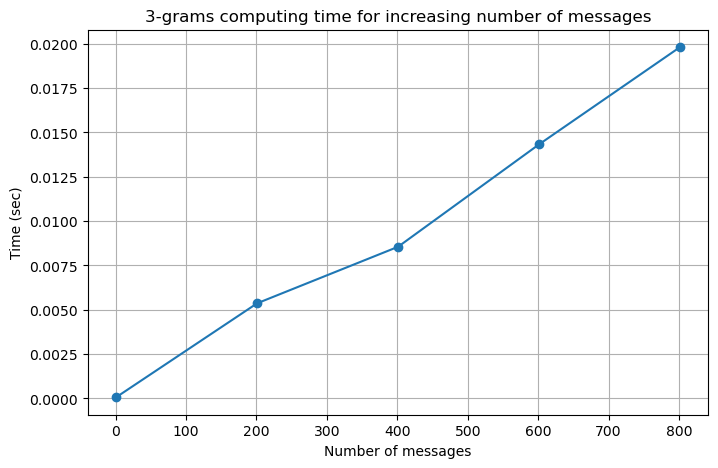

In [68]:
x_values = range(1, 1001, 200)
y_times = []

for n in x_values:
    start = timer()
    for msg in messages[:n]:
        _ = ngrams(msg, 3)
    
    end = timer()
    elapsed = end - start
    y_times.append(elapsed)

plt.figure(figsize=(8,5))
plt.plot(x_values, y_times, marker='o')
plt.title("3-grams computing time for increasing number of messages")
plt.xlabel("Number of messages")
plt.ylabel("Time (sec)")
plt.grid(True)
plt.show()

Next, fit by trial and error a quadratic curve `y = a * (x**2.0)` to what you see in the plot. For instance (you will need to modify the coefficients below to make this fit):

```python
time_estimated = [(0.0002*(n**2.0)) for n in number_messages]
...
plt.plot(number_messages, time_required, label='Experimental')
plt.plot(number_messages, time_estimated, label='Estimation')
```

Remember to include titles for the plot and the axes and the [legend](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html) of the plot.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your estimate for how long it would take to run the brute force similarity computations for the entire input set (35,500 messages). Express your estimation in human terms (e.g., hours, or days) using [timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) and [humanize](https://pypi.org/project/humanize/). Justify precisely your calculations.</font>

In [83]:
!pip install humanize

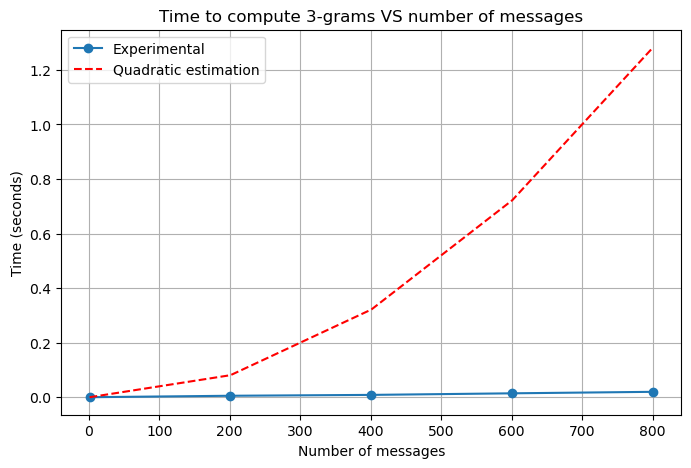

Estimated time for 35,500 messages: 42 minutes and 0.50 seconds


In [89]:
from datetime import timedelta
import humanize

number_messages = list(x_values)
time_required = y_times

a = 0.000002  # <--  we should try different experimental values to see which works the best
time_estimated = [a * (n ** 2.0) for n in number_messages]

plt.figure(figsize=(8,5))
plt.plot(number_messages, time_required, 'o-', label='Experimental')
plt.plot(number_messages, time_estimated, 'r--', label='Quadratic estimation')
plt.title("Time to compute 3-grams VS number of messages")
plt.xlabel("Number of messages")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()

n_total = 35500
estimated_seconds = a* (n_total ** 2.0)
estimated_time = timedelta(seconds=estimated_seconds)
print("Estimated time for 35,500 messages:", humanize.precisedelta(estimated_time))


# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

In real-world implementations, this is done by hashing the ngrams and then every row is an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 4.1 Create list of all ngrams

Implement code to create:

* the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number),
* the dictionary `index_to_ngram`, which should convert an index to an ngram, and
* the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

You can use the following template:

```python
NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
```

Note that the total number of n-grams may vary depending on ho you `clean()` text. In this dataset it should be about 10 times the number of documents.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [93]:
NGRAM_SIZE = 3
ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1

num_distinct_ngrams = next_index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))


There are 8762 distinct ngrams in the 1000 documents


Test your function by printing the `ngram_to_index` of the strings `els restaurants han reduir` and `supera fins tot mateix`. The exact index varies,  depending on how you `clean()` text. What is important is that when you print the `index_to_ngram` of the returned index, it should give you the same string. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [96]:
test_ngrams = ["els restaurants han reduir", "supera fins tot mateix"]

for test_ngram in test_ngrams:
    if test_ngram in ngram_to_index:
        idx = ngram_to_index[test_ngram]
        print(f"ngram_to_index['{test_ngram}'] = {idx}")
        print(f"index_to_ngram[{idx}] = '{index_to_ngram[idx]}'\n")
    else:
        print(f"'{test_ngram}' not found in ngram_to_index\n")


'els restaurants han reduir' not found in ngram_to_index

'supera fins tot mateix' not found in ngram_to_index



## 2.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row should be an n-gram, and each column should be a document.

There might be documents having less than *NGRAM_SIZE* words and thus containing no shingles. You can skip those documents above (when reading the file), or handle them here.

The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, and then try again.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [98]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 8762 rows (distinct shingles) x 1000 columns (distinct documents)


Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`.

You can use the following template:

```python
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [100]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram in ngram_to_index:
            row = ngram_to_index[ngram]
            M_ngram_doc[row, docid] = True

Measure the density of this matrix, as a percentage. This is the number of non-zeroes in the matrix as a percentage of the number of cells of the matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage. Use 4 decimals.</font>

In [104]:
num_true = np.count_nonzero(M_ngram_doc)
total_cells = M_ngram_doc.size
density = (num_true / total_cells) * 100
print("Matrix density: %.4f%%" % density)

Matrix density: 0.1439%


Print a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes. For instance, for docid **16** you should print something like this:

```
Positions of non-zeros in column of docid 16 of M_ngram_doc

Clean message:
 emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaaments de cap de setmana tot el que sigui ma

Non-zeros in corresponding row:
 ['195 (emergenciescat warning demana)', '196 (warning demana ciutadania)', '197 (demana ciutadania limitar)', '198 (ciutadania limitar maxim)', '199 (limitar maxim pot)', '200 (maxim pot evitar)', '201 (pot evitar desplacaments)', '202 (evitar desplacaments cap)', '203 (desplacaments cap setmana)', '204 (cap setmana tot)', '205 (setmana tot que)', '206 (tot que sigui)']
```

Note that the specific ngram ids you will get depend on your cleanup process, and that the output is in ascending order of ngram number, not in the same ordering in which the ngrams appear in the message.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [116]:
def print_ngram_row(row_id):
    # check if row is valid, or if it's out of bounds
    if row_id >= M_ngram_doc.shape[0]:
        print(f"\nError! Row index {row_id} is out of bounds. The matrix has only {M_ngram_doc.shape[0]} rows.")
        return

    row = M_ngram_doc[row_id, :]
    nonzero_docs = np.nonzero(row)[0]
    
    print(f"\nPositions of non-zeros in row {row_id} of M_ngram_doc")
    print(f"Ngram: '{index_to_ngram[row_id]}'")
    print(f"Documents containing this ngram: {nonzero_docs.tolist()}")

print_ngram_row(9602) 
print_ngram_row(941)


Error! Row index 9602 is out of bounds. The matrix has only 8762 rows.

Positions of non-zeros in row 941 of M_ngram_doc
Ngram: 'diverses mesures urgents'
Documents containing this ngram: [74, 75]


# 3. Implement a permutation generator

Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function [random.shuffle](https://docs.python.org/3/library/random.html#random.shuffle) might be useful. If you want to use `range(...)`, which returns an iterator, you will need to convert the iterator to a list by using `list(range(...))`.

Remember to test your code. For instance, a permutation of 20 elements should look like this:

```
[14, 10, 0, 8, 4, 12, 5, 19, 6, 9, 15, 13, 16, 2, 17, 11, 7, 3, 18, 1]
```

Every number appears only once, and all numbers from 0 to 19 appear in the permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [118]:
import random

def random_permutation(k):
    numbers = list(range(k))
    random.shuffle(numbers)
    return numbers

K_TEST = 20

print(f"Generating a random permutation of {K_TEST} elements:")
permutation_result = random_permutation(K_TEST)
print(permutation_result)

Generating a random permutation of 20 elements:
[4, 17, 5, 0, 2, 7, 1, 15, 12, 19, 16, 14, 8, 3, 9, 18, 11, 13, 10, 6]


Further test this by applying the same permutation on two lists. The code below, which you must leave as-is,  should print both lists in the same ordering, so that *alpha* is in the same position of *a*, *beta* in the same position as *b*, and so on.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [120]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (test3)', '5 (test5)', '1 (test1)', '2 (test2)', '4 (test4)']
['3 (beta)', '5 (epsilon)', '1 (alpha)', '2 (gamma)', '4 (delta)']

Test another permutation
['5 (test5)', '4 (test4)', '3 (test3)', '2 (test2)', '1 (test1)']
['5 (epsilon)', '4 (delta)', '3 (beta)', '2 (gamma)', '1 (alpha)']


# 4. Compute the signature of each document

Now comes the core of the algorithm. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [137]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 8128, 2543, 924, 412, ...
Permutation 1: 8672, 5061, 4794, 2931, ...
Permutation 2: 8368, 2354, 1308, 6407, ...
Permutation 3: 5447, 2053, 5823, 7091, ...
Permutation 4: 2756, 1185, 2075, 3417, ...


Now, you implement the signature construction. The matrix `M_signature_doc` should contain in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

This process may take a few minutes to be completed. You can use the following template:

```python
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The following function, which you should leave as-is, finds the first n-gram that appears in a document, according to the ordering defined by a permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [139]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [141]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        signature_value = find_first_one(docid, permutation)
        M_signature_doc[permutation_num, docid] = signature_value
print("\nFinished creating the signature matrix.")

Creating signatures for permutation 1/5
- Scanning document 0 of 1000
Creating signatures for permutation 2/5
- Scanning document 0 of 1000
Creating signatures for permutation 3/5
- Scanning document 0 of 1000
Creating signatures for permutation 4/5
- Scanning document 0 of 1000
Creating signatures for permutation 5/5
- Scanning document 0 of 1000

Finished creating the signature matrix.


Test your code by checking the signatures of two documents that are near-duplicates,using the next code, which you should leave as-is. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

Note that your ngrams and signatures vectors might be different than what we show here, given the differences in cleaning procedures and the randomness of the permutations.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [146]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    #for ngram_index in extract_ngrams(i):
    #   print("     ", index_to_ngram[ngram_index])
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 850 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 400 )

Document #850
Message       : RT @btvnoticies: DIRECTE | Quim Torra anuncia el confinament de tot Catalunya

Pots seguir-ho en #directebetevé aquí ⤵

https://t.co/vW0uEY…
Clean message : btvnoticies directe quim torra anuncia el confinament de tot catalunya pots seguirho en directebeteve aqui arrowheadingdown
Ngrams        : [3990, 3991, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764]
Signature     : [7758.0, 7760.0, 7759.0, 7759.0, 7758.0]

Document #400
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat redcircle el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau
Ngrams        : [3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996]
Signature     : [3991.0, 3994.0, 3990.0, 3993.0, 3994.0]


# 5. Compare all pairs of signatures

Now we are ready to compare all documents by their signatures, instead of by their content.

We will consider that if two documents have *similarity == 1.0* they are a *full signature match*, and if two documents have *0.2 < similarity < 1.0* they are a *partial signature match*. In both cases, this may mean the documents are duplicates or near duplicates.

Write code to compare all pairs of documents. Use the following template:

```python
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # REPLACE THIS COMMENT WITH YOUR CODE:
                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed

        # REPLACE THIS COMMENT WITH YOUR CODE
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least X signature matches, considering both full matches and partial matches. X should be 0.5% of the  number of documents.</font>

In [150]:
threshold = int(0.005 * len(messages))
if threshold < 1:
    threshold = 1
print(f"Using a match threshold of {threshold} (0.5% of {len(messages)} documents).")
print("Scanning for near-duplicates...")

is_possible_duplicate = {}
for docid1 in range(len(messages)):
    if docid1 not in is_possible_duplicate:
        count_sig_full_matches = 0
        count_sig_partial_matches = 0
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))
        for docid2 in range(docid1 + 1, len(messages)):
            if docid2 not in is_possible_duplicate:
                signature2 = extract_signature(docid2)
                similarity = jaccard_similarity(signature1, signature2)
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = docid1 
                elif similarity > 0.2:
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = docid1
        total_matches = count_sig_full_matches + count_sig_partial_matches
        if total_matches >= threshold:
            print(f"Document #{docid1}, found with {total_matches} potential duplicate(s):")
            print(f"  - Full signature matches (similarity=1.0):   {count_sig_full_matches}")
            print(f"  - Partial signature matches (0.2<sim<1.0): {count_sig_partial_matches}")
            print(f"ORIGINAL MESSAGE: {messages[docid1]}")

Using a match threshold of 5 (0.5% of 1000 documents).
Scanning for near-duplicates...
0/1000 documents scanned
Document #2, found with 5 potential duplicate(s):
  - Full signature matches (similarity=1.0):   5
  - Partial signature matches (0.2<sim<1.0): 0
ORIGINAL MESSAGE: RT @XSalaimartin: Fa temps que sabem que aquest tal Garcia-Page és un miserable. Però amb això se supera fins i tot a sí mateix. https://t.…
Document #16, found with 7 potential duplicate(s):
  - Full signature matches (similarity=1.0):   6
  - Partial signature matches (0.2<sim<1.0): 1
ORIGINAL MESSAGE: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Document #20, found with 5 potential duplicate(s):
  - Full signature matches (similarity=1.0):   3
  - Partial signature matches (0.2<sim<1.0): 2
ORIGINAL MESSAGE: RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇

🔗

**⚠️ IMPORTANT:** Once you have completed the development, set MAX_MESSAGES to 10000 and run your code again (skip the part on estimating for the brute-force method, you do not need to re-estimate that). This will scan a larger number of tweets and allow you to answer the questions below.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

<font size="+1" color="black"> 
If we take a look at the results of signature comparison, there are patterns that all tweets from announcements or alerts follow. These usually have differences, but keep matches. Some example could be:

ORIGINAL: RT @emergenciescat: #ProteccioCivil demana a la ciutadania limitar al màxim i si es pot evitar desplaçaments de cap de setmana tot el que sigui...

These official announcements, like Catalonia's Civil Protection agency, are often copied exactly, giving rise to full matches and a few partial matches. This objective information that needs to be transmitted, of course, can be said differently, but the things that must be transmitted are exactly the same accurate events. This happens because these tweets are factual, the easiest way to share is by retweeting (perfect copy of the original), and they are authoritative.

</font>

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

<font size="+1" color="black">
In this case, take a look at:

ORIGINAL: Per responsabilitat, per solidaritat, per tu, per mi i per a tots #JoEmQuedoACasa

NEAR DUPLICATE: Per la meva família, per les meves amigues i per tot el personal sanitari que s'hi està deixant la pell... #JoEmQuedoACasa

In these ones, the concept that is wanted to be shared is the same, but each person who participates adds a personal feature. They all share the same hashtags and are giving support to the same motive, but each of them is doing it subjectively.  


</font>

# DELIVER (individually)

Set `MAX_MESSAGES` back to *1000* before delivering. There is no need for you to re-run your code, it just helps the reviewing.

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, choose **one** of these two activities:

* see what happens with smaller and larger ngram sizes (2-grams, 4-grams, 5-grams)
* see what happens with more permutations and fewer permutations (3 permutations, 10 permutations)

Pick one of the two above and compare them in terms of the efficiency (speed) and effectiveness (accuracy). You can include plots for efficiency, and examples for effectiveness.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: variations in ngram sizes or number of permutations</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>